In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cluster_model import ClusterModel
from datetime import timedelta
import pickle
import seaborn as sns

In [2]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

In [9]:
cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.004)
cluster_model.init_clusters()
cluster_model.init_state(path='../data/station_data/status_at_time/2024_6_20_2:19.csv', time=timedelta(hours=2))
# cluster_model.show_bikes()

# num_stations = [len(cluster) for cluster in clusters]
# sns.heatmap(np.array(num_stations).reshape((vertical_squares, horizontal_squares)))

45 horizontal squares and 64 vertical squares. Total squares: 2880


2:15:00
63 in transit
80 failures
28 critical failures
0 total trips
-------------------
2:30:00
69 in transit
131 failures
42 critical failures
49 total trips
-------------------
2:45:00
89 in transit
179 failures
53 critical failures
102 total trips
-------------------
3:00:00
57 in transit
207 failures
64 critical failures
173 total trips
-------------------
3:15:00
61 in transit
240 failures
69 critical failures
220 total trips
-------------------
3:30:00
52 in transit
269 failures
76 critical failures
274 total trips
-------------------
3:45:00
63 in transit
290 failures
79 critical failures
317 total trips
-------------------
4:00:00
66 in transit
313 failures
80 critical failures
369 total trips
-------------------
4:15:00
53 in transit
333 failures
83 critical failures
427 total trips
-------------------
4:30:00
74 in transit
356 failures
88 critical failures
469 total trips
-------------------
4:45:00
92 in transit
393 failures
93 critical failures
534 total trips
------------

magick: unable to open image 'images/bikes/*.png': No such file or directory @ error/blob.c/OpenBlob/3596.


0

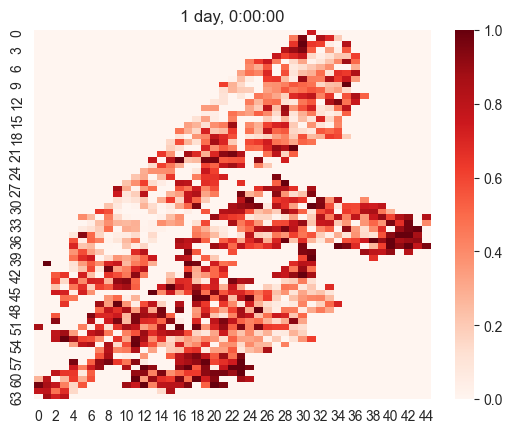

In [11]:
end_time = cluster_model.curr_time + timedelta(hours=22)
image_number = 0
while cluster_model.curr_time < end_time:
    cluster_model.sim()
    print(cluster_model.curr_time)
    print(len(cluster_model.in_transit), 'in transit')
    print(cluster_model.failures, 'failures')
    print(cluster_model.critical_failures, 'critical failures')
    print(cluster_model.total_trips, 'total trips')
    print('-------------------')
    if image_number < 10:
        t = f'000{image_number}'
    elif image_number < 100:
        t = f'00{image_number}'
    elif image_number < 1000:
        t = f'0{image_number}'
    else:
        t = f'{image_number}'
    cluster_model.show_bikes(save=True, name=f'{t}')
    cluster_model.show_fill_percent(save=True, name=f'{t}')
    image_number += 1
    
os.system('magick images/bikes/*.png gifs/bikes.gif')
os.system('magick images/fill/*.png gifs/fill.gif')


In [12]:
test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
test2 = [i for i in test for _ in range(3)]
test2

[0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9]

<Axes: title={'center': '2:00:00'}>

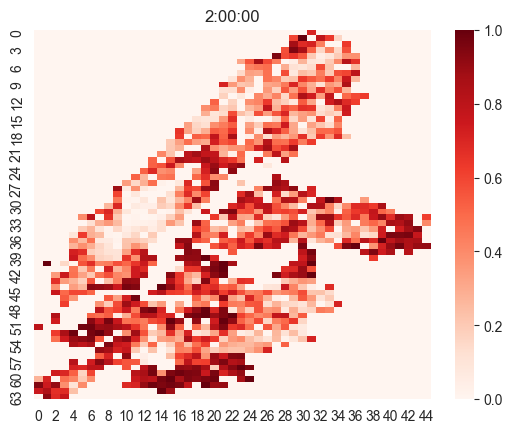

In [10]:
# cluster_model.show_bikes()
cluster_model.show_fill_percent()

In [28]:
cluster_model.sim()
print(cluster_model.curr_time)
print(len(cluster_model.in_transit))
print(cluster_model.failures)
print(cluster_model.critical_failures)

13:45:00
1435
986
37
